# Checkpoint 3: Variational Autoencoder & Generative and adversarial models
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)


Quickdraw was an interesting dataset but requires quite a lot of CPU to get decent results. We discussed a relatively good solution to the problem in the Lecture, but it is quite CPU intensive.

In order to make life a little easier in terms of training time, in this checkpoint exercise we will work with the MNIST dataset of hand-written digits. This time, though, we won't be classifying existing images, we will be generating new ones with generative models. 

- Exersice 1 and 2 we will build and use a Variational Autoencoder
- Exersice 3 we will use a Generative Adeverserial Network


These exercises build quite heavily on the ones in CP2. The network structure that worked on quickdraw should translate pretty well to MNIST, and hopefully perform better. You may be able to reuse some of your work, or you can look at my proposed solutions from last time for inspiration.


### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 29 November 2020** 
- This CP exercise sheet is divided into **3 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title                        | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ------------------------------------------------------ | --------------------- | ------------------ |
| <p align='left'> 1. Build VAE                          | <p align='left'> 1–3  | <p align='left'> 4 |
| <p align='left'> 2. Compile and train a VAE            | <p align='left'> 4–6  | <p align='left'> 4 | 
| <p align='left'> 3. Generative adversarial network     | <p align='left'> 7–9  | <p align='left'> 2 |
| <p align='left'> **Total**                             |                       | <p align='left'> **10** |

## Preamble
---

In [59]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last



## Data preprocessing
---

First, we'll load in the MNIST dataset from TensorFlow, which has already been split into training and testing parts for us.

In [3]:
# Load in MNIST dataset 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Get numbers
nb_train   = X_train.shape[0]
nb_test    = X_test .shape[0]
nb_classes = y_train.max() + 1
print(f"Number of training examples: {nb_train}")
print(f"Number of testing  examples: {nb_test}")
print(f"Number of target classes:    {nb_classes}")

# Reshape inputs to (N,N,1), i.e. have one colour dimension
X_train = X_train[..., np.newaxis]
X_test  = X_test [..., np.newaxis]

# Standardise inputs
print("Max. input before scaling: {}".format(X_train.max()))
X_train = X_train / 255.
X_test  = X_test  / 255.

# Get image shape
shape = X_train.shape[1:]
print(f"Image shape:  {shape}")

# Shuffle (dataset is pre-shuffled, but still)
ix_train = np.random.permutation(nb_train)
ix_test  = np.random.permutation(nb_test)

X_train = X_train[ix_train]
y_train = y_train[ix_train]

X_test  = X_test [ix_test]
y_test  = y_test [ix_test]


11493376/11490434 [==============================] - 25s 2us/step
Number of training examples: 60000
Number of testing  examples: 10000
Number of target classes:    10
Max. input before scaling: 255
Image shape:  (28, 28, 1)


The image below shows labels and images associated to them. They are in our standard (28,28,1) image format, as we had in quickdraw.

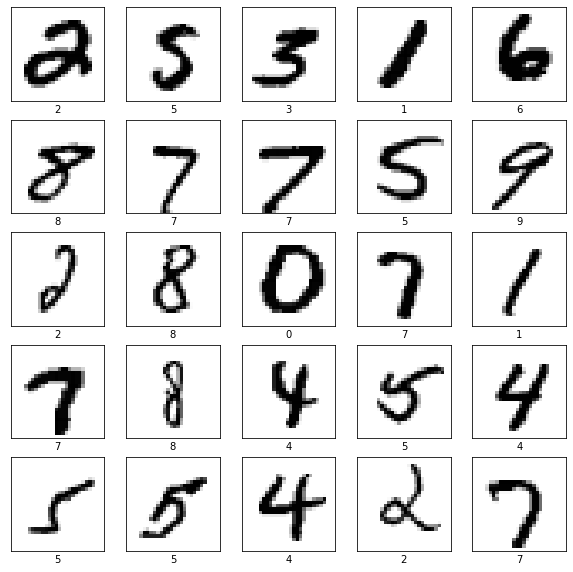

label marks [2 5 3 1 6 8 7 7 5 9 2 8 0 7 1 7 8 4 5 4 5 5 4 2 7]


In [4]:
nb_show = 25
plt.figure(figsize=(10,10))
for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
print("label marks",y_train[:nb_show])

## Variational auto-encoder (VAE) utilities
---
Below, I am providing you with some utility methods for training VAEs. This is done to minimsie the overhead in getting you up and running and training cool neural networks.

The first function implements the crucial element for _variational_ auto-encoders: The random sampling in the latent space. The `sampling` function below takes one argument, which is assumed to be a list with two element: the means and the logarithm of the variances, respectively, of the latent probability density function (p.d.f.) for a given image example. The function then samples random numbers, and scales them such that they are effectively drawn from a p.d.f. with means and standard deviations as given by `args`. These sampled coordinates in the latent space are then returned.

In [33]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Build a VAE (4 marks)

#### 1. Build the encoder of the VAE (1.5 mark)

Build an encoder. We will train for 50 epoches so a relatively fast NN may be desiriable. Here you have some freedom but some example structure is given:
- the input layer has the dimension of the shape
- Flat the input layer (either with or without convolution beforehand)
    - The `1 2 4 8 16` convolution example worked well for me, but is a bit slower.
- add a few hidden Dense layer (with relu activation function) with 256 dimension of hidden nodes
- Add the 2 special layers:
    * `z_mean` contains the means of the latent space p.d.f. for a given image, and
    * `z_log_var` contains the logarithm of the assocated variances. 
- Pass these 2 layers into a layer `z` that just apply the `sampling` method above. Note: the sampling method is used to perform the reparametrization trick. `Lambda` has to be used to ensure the gradients to be computed (see Lecture example) 
- Output the 3 layers (z_mean, z_log_var and z)
- build the encoder model with the `Model` method. 
    - If you used convolution and pooling make sure you complient this with Upsampleling and ConvolutionTranspose. 
    - A good structure here is to invert the stucture of the encoder, e.g. `16 8 4 2 1`.

In [65]:
intermediate_dim =256
latent_dim = 2

In [155]:
#input layer is an input with shape of the image
visible = Input(shape=(28,28,1))
#flatten the visible layer
flat = Flatten()(visible)
#hidden layer of 256 nodes and activation relu
hidden1 = Dense(intermediate_dim, activation='relu')(flat)
#second hidden layer of 256 nodes and actiavtion relu
hidden2 = Dense(intermediate_dim, activation='relu')(hidden1)
#mean and variance layers both passed into the previous layer
z_mean = Dense(latent_dim, name='z_mean')(hidden2)
z_log_var = Dense(latent_dim, name='z_log_var')(hidden2)

In [156]:
#passing mean and variance to new layer z
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [158]:
#make encoder with input layer the images, the output layer mean,var and z
encoder = Model(visible, [z_mean, z_log_var, z], name='encoder')
#generate the summary to look at layer structure
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_26 (Flatten)            (None, 784)          0           input_54[0][0]                   
__________________________________________________________________________________________________
dense_73 (Dense)                (None, 256)          200960      flatten_26[0][0]                 
__________________________________________________________________________________________________
dense_74 (Dense)                (None, 256)          65792       dense_73[0][0]                   
____________________________________________________________________________________________

#### 2. Build the decoder of the VAE (1.5 mark)

Build a decoder:
- the input layer has the latent space 2
- Apply 2 hidden Dense layers with dimension 256 (same number as in the encoder) and relu activation function
- Output sigmoid activation function such that it ends up with the same shape as the original image, with pixel intensities in the range $[0, 1]$.
    - use as dimension of this layer `np.prod(shape)`, where shape is the latent space.
- then reshape the output to the original image shape with `Reshape` method. This step is needed to bring back the data from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last layer of our encoder.
- build the decoder model with the `Model` method

In [171]:
#check dimensions of variable 'shape'  
shape

(28, 28, 1)

In [172]:
#create decoder
#input has shape of latent dimensions ,2, as given by output of encoder
dec_input = Input(shape=(latent_dim, ))
#two dense layers (same as encoder) of 256 nodes, relu activation function
x = Dense(intermediate_dim, activation='relu')(dec_input)
x = Dense(intermediate_dim, activation='relu')(x)
#output of dense layer of shape and sigmoid activation for binary classification
output = Dense(np.prod(shape),activation='sigmoid')(x)
#reshape output to image dims
output = Reshape((28,28,1))(output)

In [173]:
latent_dim

2

In [174]:
#generate decoder with 2 dim input and 28,28,1 output
decoder = Model(dec_input, output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_78 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_79 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_80 (Dense)             (None, 784)               201488    
_________________________________________________________________
reshape_11 (Reshape)         (None, 28, 28, 1)         0         
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


#### 3. Build the VAE model (1 mark)

Then, we can connect the encoder and the decoder. 
- Build the VAE model using `Model` method using `i` (encoder) and `o` (decoder)
- plot the model with the `plot_model` method

In [175]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

In [176]:
#generate variational auto encoder which takes in the encoder and outputs the decoder
vae = Model(inputs=i, outputs=o, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 267780    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         268048    
Total params: 535,828
Trainable params: 535,828
Non-trainable params: 0
_________________________________________________________________


# Compile and train the VAE model (3 marks)

The `compile_vae` methods compiles the VAE model passed as the sole argument. The method computes

1. the image reconstruction loss (`reco_loss`), as well as
2. the Kullback-Leibler (KL) loss (`kl_loss`) for the latent space p.d.f.

The first loss measures how well the VAE is doing at reconstructing the input images; the second loss quantifies how continuous the latent representation is. The two losses are then summed (and added as separate metrics for monitoring), and the VAE model is compiled with the Adam optimiser.

In [177]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

#### 4. Construct, compile, and train a VAE using the methods provided above (1 mark)

* Display the model using the `plot_model(vae, show_shapes=True)` method, to validate that it looks as expected.
* Compile the model.
* Plot the all of the loss histories in `vae.history.history`. Use a suitable fraction of training data for validation
* train for 50 epochs

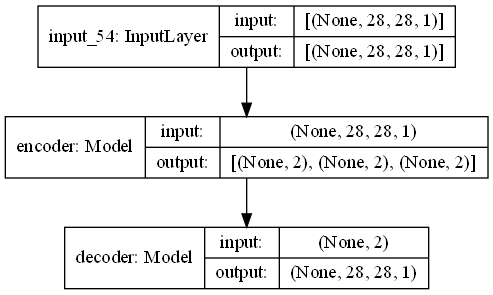

In [178]:
#display varational autoencoder structure
plot_model(vae, show_shapes=True)

In [179]:
# Define parameters
latent_dim =  2
nb_epochs  =  50
batch_size = 128

In [180]:
#compile variational autoencoder
compile_vae(vae)

In [385]:
#train model using 20% for validation
history_vae = vae.fit(X_train,X_train, batch_size=128, epochs=50, shuffle=True,validation_split=0.2);

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 8s 161us/sample - loss: 136.2527 - reco_loss: 129.3136 - kl_loss: 6.9391 - val_loss: 138.0236 - val_reco_loss: 131.1239 - val_kl_loss: 6.8996
Epoch 2/50
48000/48000 [==============================] - 6s 129us/sample - loss: 135.7807 - reco_loss: 128.8093 - kl_loss: 6.9713 - val_loss: 138.1064 - val_reco_loss: 131.1255 - val_kl_loss: 6.9809
Epoch 3/50
48000/48000 [==============================] - 6s 128us/sample - loss: 135.7013 - reco_loss: 128.7287 - kl_loss: 6.9726 - val_loss: 138.4641 - val_reco_loss: 131.4890 - val_kl_loss: 6.9750
Epoch 4/50
48000/48000 [==============================] - 6s 117us/sample - loss: 135.5444 - reco_loss: 128.5808 - kl_loss: 6.9636 - val_loss: 138.1130 - val_reco_loss: 131.1546 - val_kl_loss: 6.9584
Epoch 5/50
48000/48000 [==============================] - 6s 123us/sample - loss: 135.5163 - reco_loss: 128.5370 - kl_loss: 6.9793 - val_loss: 138.190

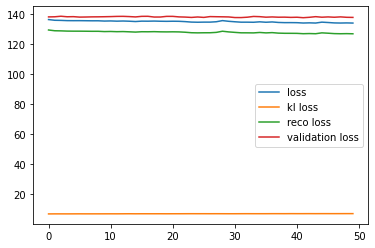

In [386]:
#get the loss functions: loss, validation loss, reconstruction loss and KL loss
loss = history_vae.history['loss']
val_loss = history_vae.history['val_loss']
reco_loss = history_vae.history['reco_loss']
kl_loss = history_vae.history['kl_loss']

#plot all loss types
plt.plot(loss,label='loss')
plt.plot(kl_loss,label='kl loss')
plt.plot(reco_loss,label='reco loss')
plt.plot(val_loss,label='validation loss')
plt.legend()

#### 5. Predict the test digits into the 2D laten space (1 mark)

- Use the encoder to predict images into the laten space
- Make a scatter plot per digit (use masking, see our first ML Lecture 2) and include a legend
- Include a grid.
- Discuss the results. Why do you think some digits overlap, and why are some clearly seperated? 

In [369]:
#get images from encoder
y_pred = encoder.predict(X_test)

In [370]:
#check indexing of images
y_pred[0]

array([[ 2.1068072 , -1.5502877 ],
       [-0.34769598, -0.3976433 ],
       [-1.9364189 , -1.3690429 ],
       ...,
       [-0.46202594,  1.4904482 ],
       [-0.11130825, -3.2511532 ],
       [ 0.6610011 , -0.6592203 ]], dtype=float32)

In [371]:
#check format of y test labels
y_test

array([5, 6, 0, ..., 9, 0, 8], dtype=uint8)

In [372]:
#test how to assign boolean mask
5 == y_test

array([ True, False, False, ..., False, False, False])

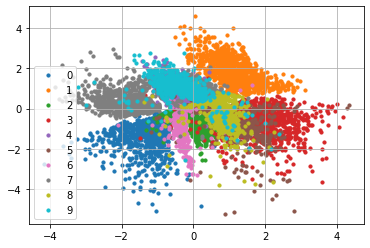

In [412]:
#generate the figure
fig, ax = plt.subplots()
#for loop for the range of numbers
for num in range(10):
    #Generate the mask for when the number is the same as the label
    mask = num == y_test
    #apply mask to the predicted images for two different features: [mask,0] and [mask,1]
    y_true_1 = y_pred[0][mask,0]
    y_true_2 = y_pred[0][mask,1]
    #plot the two images with the mask applied against eachother
    ax.scatter(y_true_1,y_true_2,label=str(num),s=10)
ax.grid()
ax.legend()

### MY COMMENTS


---


This scatter plot compares the numbers against eachother for the latent space. As you can see, the model is quite good at seperating some numbers, such as 1 (orange), 0 (blue), 7 (grey), and less successful at distinguishing between 9 (cyan), and 4 (purple). 8 (lime) and 5 (brown) are close to eachother, which can be explained by the similar features such as the lower right curve on both, also 5 and 3 (red) are similar due to their similar curvature.  

#### 6. Generate samples across the latent space of the VAE (2 marks)

* Define an equally-spaced set of $\boldsymbol{N \approx 10}$ **points** along each of the two latent dimensions, that you want to sample (_e.g._ using the `np.linspace` method in the range $(-2,2)$). You can play around with this range in order to focus on areas you personally think might be interesting (look at your grid plot above).
* Convert these into a grid of pairs of coordinates using the `np.meshgrid` method.
* Define an $(N^{2}, 2)$ array, and fill it with all of these pairs of latent space coordinates (you'll need to `flatten` the two outputs from `np.meshgrid`).
* Get the decoder predictions (_i.e._ the generated images) for this set of $N^{2}$ coordinates in the latent space.
* Display them in a grid, _e.g._ using the `plt.imshow` method.
* Discuss the results.

In [340]:
#generate mesh grid from -2 to 2 in two dimensions for ten samples
Xgrid, Ygrid = np.meshgrid(np.linspace(-2,2,10),np.linspace(-2,2,10))

In [342]:
#flatten the mesh grid outputs
X_flat = Xgrid.flatten()
Y_flat = Ygrid.flatten()
#form a grid of 0s for N^2 (10^2 = 100) entries, in 2 dimensions, x and y dimensions
grid = np.zeros((10**2,2))
#change all the rows in first column to the x values
grid[:,0] = X_flat
#change all the rows in second column to the y values
grid[:,1] = Y_flat
#this gives pairs of (x,y) coordinates

In [413]:
#check grid
grid

array([[-2.        , -2.        ],
       [-1.55555556, -2.        ],
       [-1.11111111, -2.        ],
       [-0.66666667, -2.        ],
       [-0.22222222, -2.        ],
       [ 0.22222222, -2.        ],
       [ 0.66666667, -2.        ],
       [ 1.11111111, -2.        ],
       [ 1.55555556, -2.        ],
       [ 2.        , -2.        ],
       [-2.        , -1.55555556],
       [-1.55555556, -1.55555556],
       [-1.11111111, -1.55555556],
       [-0.66666667, -1.55555556],
       [-0.22222222, -1.55555556],
       [ 0.22222222, -1.55555556],
       [ 0.66666667, -1.55555556],
       [ 1.11111111, -1.55555556],
       [ 1.55555556, -1.55555556],
       [ 2.        , -1.55555556],
       [-2.        , -1.11111111],
       [-1.55555556, -1.11111111],
       [-1.11111111, -1.11111111],
       [-0.66666667, -1.11111111],
       [-0.22222222, -1.11111111],
       [ 0.22222222, -1.11111111],
       [ 0.66666667, -1.11111111],
       [ 1.11111111, -1.11111111],
       [ 1.55555556,

In [343]:
#get predicted images from decoder
dec_pred = decoder.predict(grid)

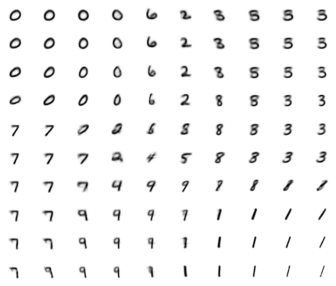

In [384]:
#show the 100 images in N^2 latent space in 10x10 subplots
figs, axs = plt.subplots(10, 10,figsize=(6,5))
count = 0
for i in range(10):
    for j in range(10):
        #plot decoded predicted image for values 1 to 100
        img = dec_pred[count]
        axs[i,j].imshow(img,cmap=plt.cm.binary)
        count += 1
        axs[i,j].set_axis_off()

plt.subplots_adjust(hspace=0.8)
plt.show()

_Indicative answer:_ This figure shows us that:
        
Using VAEs, we're able to generate new images that look like the original ones. That's a pretty big thing, and something we couldn't do with a standard (non-variational) auto-encoder.


# Generative Adversarial networks (2 marks)

Putting together a GAN by yourself is a big task and outside the scope of what we can cover.

Instead here we provide the building blocks for creating the GAN on the MNIST dataset. Your task is to go through individual components and show your understanding. The source material can be found [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) with ample explenations, so think of it as a short literature review, the point being to get you to engage with the material.


**Suggestion**: you could choose to answer the question in the same markdown block they are asked. Make the answer distiguishable by for example using a seperator by typing `---` on a new line.



#### 7. Discuss components of generative adverserial NN (0.5 marks)




In [349]:
# all imports needed from here
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.python.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import Conv2DTranspose
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.python.keras.layers import Dropout
from matplotlib import pyplot

---

- Defined is the discriminator model using the `Sequential` keras function
    - What is the purpose of the discriminator?
    - Discuss the structure. What are the LeakyReLU and Dropout layers?
    - Why is binary crossentropy used as the loss function?

---
### MY ANSWERS
1. A discriminator identifes fake data from real data. the fake data is produced by the generator and the real data is the input images. it is trained on both the real and fake data and its role is to distinguish between them by assigning a probability as to wether its fake (0) or real(1). the generator is trained via the discriminator.


2. Structure: instead of pooling, convolution layers are used for downsampling. the dropout layers (dropout of 40%) remove the nodes between the layers, in order to prevent over-fitting and memorization. The activation function used in each layer is a leaky ReLU. The leaky relu function is linear regression, however unlike relu it doesn't let nodes die for values less than 0, it gives a very small value instead of 0 for negative values. this means the nodes do not die and are updated, so stops you loosing variables. the output function is `sigmoid`, this assigns a scalar value of the probability of how real the image is nearer to 0 means more probability of fake, and closer to 1 is closer to real, which is what we need the discriminator to do.


3. binary cross entropy is used as the loss function of the discriminator as the discriminator wants to identify fake data, thus they want to compare the fake data and real data against eachother, one is trying to maximise the probability (1) and one is trying to minimize the probability (0). the loss function of the discriminator trains the generator and so this loss function is necessary so that the generator can improve its fake data by looking at the binary cross entropy, how close it is to fake/true. cross-entropy is the default loss function to use for binary classification problems, as it has target values 1 and 0.



In [350]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 3136)              0

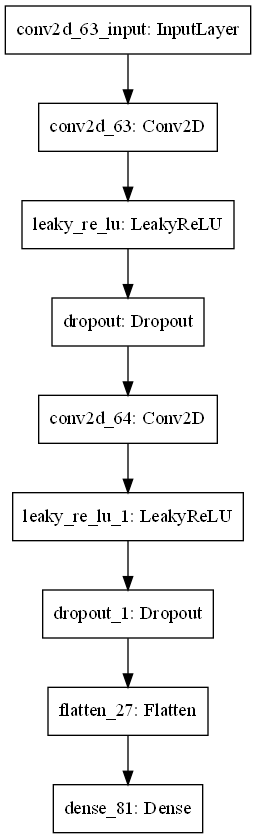

In [351]:
# create the discriminator
d_model = define_discriminator()
d_model.summary()
plot_model(d_model)

---
- Defined is the generator model
    - What is used as input to the generative model?
    - What is the Conv2DTranspose layer used for?
    - Why is sigmoid used as the activation function?

### MY ANSWERS
---
1. The input, `model.add(Dense(n_nodes, input_dim=latent_dim))`, is a dense layer with dimensions the same as the latent dimensions (2) with 7x7 pixels per filter with 128 filters, so a total of 6272 nodes. This is for a batch size of 128 and 7x7 image. This input takes in noise and turns it into a fake image.


2. The `Conv2DTranpose` layer is the inverse of the convolution, used to generate a fake image is generated from noise (dense layer with leaky relu) which upsamples the data. it also learns which is the best upsampling to use, unlike `Upsampling2d`.


3. The output of the sigmoid at the last layer produces the fake image. Sigmoid is for binary classification probability (0,1), which allows us to use binary cross entropy loss and class the images as real or fake

In [352]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

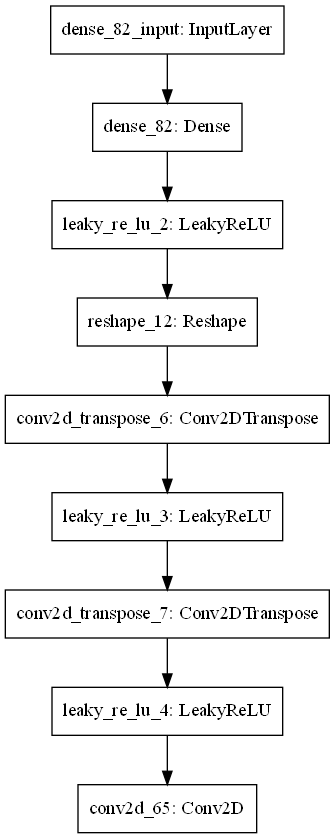

In [353]:
# size of the latent space
latent_dim = 100
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()
plot_model(g_model)

---
- We define the GAN model as a sequence of both generator and discriminator
    - Explain the order of the sequence, and the flow of input to output, through the generator and discriminator
    - Notice the discriminator is not trainable in the gan model. Can you think of why that might be? This may become clear when we discuss the training loop.

### MY ANSWERS
---
1. The sequence of the GAN is first the generator, and then the discriminator. the generator takes in noise in a dense layer for 7x7 image, which is then upsampled to a 14x14 image, which is then finally upsampled and reshaped to image dimensions 28x28. The output is one node which uses the sigmoid function, giving 1 and 0 to determining real or fake images. The generated 28x28 image is fed into the discriminator along with the real images. The discriminator then takes in this 28x28 image, applies convolution, applies leaky relu to assign 1 and 0 to the next layers, drops out some of the nodes to prevent over fitting. This is then repeated and the images are then flattened and returns a  true or false (real / fake) probability using sigmoid function.


2. The discrimator is not trainable as you do not want it to learn the fake data. If it did learn the fake data, it would not be able to distinguish between the true data, as anything it was then fed it would label as fake. As we want it to distinguish between real and fake with increasing accuracy, we make it untrainable in the GAN model. 

In [354]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


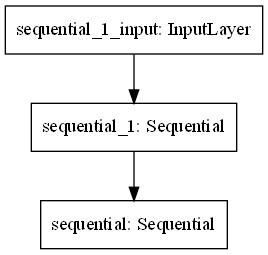

In [355]:
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model)

---
##### 8. Discuss the training datasets (0.5 marks)

- Given are real mnist datasets. 
- `load_real_samples` prepares mnist
- `generate_real_samples` allows us to select a subset of data for barch training
    - what is this data used for?
    - what is the `y = ones((n_samples, 1))` varible used for?

### MY ANSWERS

---

1. `generate_real_samples` is a small random batch of the dataset, small batches are used here to compare to the fake data. it is small as it is noisy so allows for training and random so there is no bias in the data. 



2. the `y = ones((n_samples,1))` is a `[Nx1]` array of ones, where N is the number of images. the ones are the 'real' class labels as this is the real data, in the dimensions of the number of images so that each image has a class label '1' because they're real

In [356]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y
 

---
- Given are functions to generate random numbers from laten space
    - use `generate_fake_samples` to create a single random image propegated through the generator. Discuss the result.

In [357]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [397]:
X,y = generate_fake_samples(g_model, latent_dim, 1)

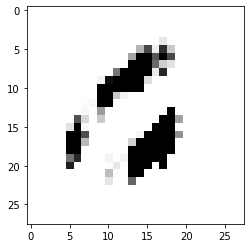

In [406]:
plt.imshow(X[0,:,:,:],cmap=plt.cm.binary)

---
COMMENT:
I trained the model in **Q9** before running this cell to save time, therefore it is trained and tries to look like an element of the dataset however it should just be noise. It should have noise with no visible structure if the generator isn't trained.

---
Some functions for saving GAN models and output images

In [358]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename) 

#### 9 Training the GANs (1 marks)

The GAN training sequnce is done in batches of data per epoch. Because the generator weights cannot be updated in the standard way, this is done iteratively in a loop. 


- Discuss the lines within the `j` loop. Explain how the generator and discriminator are trained in this context. 

### MY ANSWERS

---

Firstly, a number of real random samples are selected and the same number of fake data is generated by generator. a training set is generated by mixing the real and fake data. The discriminator is trained on this batch and its weights updated. Points are generated in the latent space as a input for the generator. The random points are fed to the generator to create fake samples. Inverted labels are generated for the fake samples, so that they are labeled as True/1. This list of trues goes into the loss calculation so that it can calculate the error. Then the generator is updated using the loss of the discriminator to generate better fake images - they train against eachother so the fake data looks more real and therefore the discriminator becomes more accurate distinguishing between the two. 

In [359]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 2 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

- Train the GAN model. 
    - This takes a very long time, so I would recommend aiming for 3 epochs and checking the figures that are generated (saved locally). They won't be good, but you will get some idea already that we don't have random noise
    - Discuss the print out. How do the loss functions change over time?
    - Generate some images with your new number generator and plot them. 
    - Feel free to try for more epoches (if you insist!). If you have some hours to waste, 10 should start showing some good digits, and by 50 you should get some good results.

In [388]:
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=3)

>1, 1/234, d=0.731, g=0.628
>1, 2/234, d=0.723, g=0.652
>1, 3/234, d=0.712, g=0.672
>1, 4/234, d=0.703, g=0.697
>1, 5/234, d=0.693, g=0.718
>1, 6/234, d=0.680, g=0.745
>1, 7/234, d=0.669, g=0.770
>1, 8/234, d=0.665, g=0.790
>1, 9/234, d=0.659, g=0.809
>1, 10/234, d=0.651, g=0.825
>1, 11/234, d=0.650, g=0.842
>1, 12/234, d=0.642, g=0.850
>1, 13/234, d=0.641, g=0.849
>1, 14/234, d=0.645, g=0.838
>1, 15/234, d=0.642, g=0.825
>1, 16/234, d=0.647, g=0.804
>1, 17/234, d=0.651, g=0.782
>1, 18/234, d=0.648, g=0.761
>1, 19/234, d=0.653, g=0.744
>1, 20/234, d=0.653, g=0.729
>1, 21/234, d=0.651, g=0.717
>1, 22/234, d=0.642, g=0.709
>1, 23/234, d=0.639, g=0.704
>1, 24/234, d=0.634, g=0.701
>1, 25/234, d=0.625, g=0.700
>1, 26/234, d=0.616, g=0.698
>1, 27/234, d=0.607, g=0.698
>1, 28/234, d=0.598, g=0.699
>1, 29/234, d=0.590, g=0.700
>1, 30/234, d=0.582, g=0.701
>1, 31/234, d=0.567, g=0.701
>1, 32/234, d=0.564, g=0.702
>1, 33/234, d=0.543, g=0.704
>1, 34/234, d=0.541, g=0.704
>1, 35/234, d=0.531, g=

In [403]:
X,y = generate_fake_samples(g_model, latent_dim, 3)

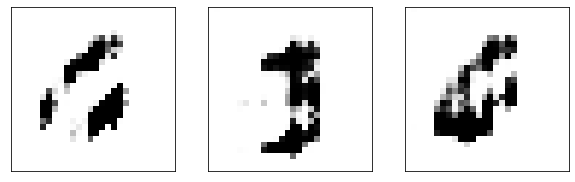

In [408]:
fig = plt.figure(figsize=(10,10))
for i in range(3):
    fig.add_subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i],cmap=plt.cm.binary)
plt.show()

### MY ANSWERS - IMAGES
--- 

These images are given by the generator after being fed random noise. Now that the model has been trained, the generator converts the random noise into images that look more like the real data set (hand drawn numbers), unlike the images generated when it has **not** been trained, which are random pixels of noise.

### MY ANSWERS - LOSS 
---

The loss of the generator and the discriminator oscillate over time: as one decreases in loss the other increases. This is because they're competing with eachother and training eachother. As the generator gets better and the generators loss decreases, the real/fake is harder to distinguish by the discriminator so its loss increases etc. However as the loss increases, the discrimator will learn better, which then leads to the low loss in discriminator and high loss in the generator. The two train eachother so whilst they oscillate with large amplitude initially, the difference starts to stabilise with more epochs. In epoch 3, the difference in loss between the generator and discriminator is a lot smaller and stable, they both have losses around 0.7. 